# Activity models

In [1]:
using Pkg, Revise
Pkg.activate("..")
using Clapeyron, PyCall
import PyPlot; const plt = PyPlot
# ternary = pyimport("ternary")

  Activating project at `~/Library/CloudStorage/OneDrive-CaliforniaInstituteofTechnology/University/UROP/SAFT_codes/Clapeyron`


PyPlot

In [2]:
revise(Clapeyron)

true

In this notebook, we will be giving examples on how to use activity models within `Clapeyron.jl`. We include examples of how one can customise their activity model and how it can be used in tangent with a cubic equation of state.

In [3]:

mapping = [(("water",1),)=>(("water",1)),
           (("methanol",1),)=>(("methanol",1)),
           (("water",1),("methanol",1))=>(("water.methanol",1))]
fluid = PCSAFT(["water","methanol"]; assoc_options=AssocOptions(combining=:elliott))
fluid.params.epsilon["water","methanol"] *= (1+0.18)
solid = SolidHfus(["water","methanol","water.methanol"])
model = CompositeModel(["water","methanol"],mapping;fluid=fluid,solid=solid)

MethodError: MethodError: no method matching CompositeModel(::Vector{String}, ::Vector{Pair{Tuple{Tuple{String, Int64}, Vararg{Tuple{String, Int64}}}, Tuple{String, Int64}}}; fluid::PCSAFT{BasicIdeal, Float64}, solid::SolidHfus)

Closest candidates are:
  CompositeModel(::Vector{String}, ::𝔽, !Matched::𝕊, !Matched::Any) where {𝔽, 𝕊} got unsupported keyword arguments "fluid", "solid"
   @ Clapeyron ~/Library/CloudStorage/OneDrive-CaliforniaInstituteofTechnology/University/UROP/SAFT_codes/Clapeyron/src/models/types.jl:26
  CompositeModel(::Any; mapping, liquid, gas, fluid, solid, saturation, melting, sublimation, gas_userlocations, liquid_userlocations, fluid_userlocations, solid_userlocations, saturation_userlocations, melting_userlocations, sublimation_userlocations, verbose)
   @ Clapeyron ~/Library/CloudStorage/OneDrive-CaliforniaInstituteofTechnology/University/UROP/SAFT_codes/Clapeyron/src/models/CompositeModel/CompositeModel.jl:95


In [ ]:
x_water = zeros(100)
T_water = LinRange(solid.params.Tm["water"]*0.9999,155,100)

for i in 1:100
    x_water[i] = sle_solubility(model,1e5,T_water[i],[1,1];solute=["water"])[1]
end

x_meoh = zeros(100)
T_meoh = LinRange(solid.params.Tm["methanol"]*0.9999,155,100)

for i in 1:100
    x_meoh[i] = sle_solubility(model,1e5,T_meoh[i],[1,1];solute=["methanol"])[1]
end

x_mix = zeros(100)
T_mix = LinRange(solid.params.Tm["water.methanol"]*0.9999,155,100)

for i in 1:100
    x_mix[i] = sle_solubility(model,1e5,T_mix[i],[1,1];solute=["water.methanol"])[1]
end

In [ ]:
plt.clf()
plt.plot(1 .-x_water,T_water,label="water")
plt.plot(1 .-x_meoh,T_meoh,label="methanol")
plt.plot(1 .-x_mix,T_mix,label="water-methanol")
plt.xlim(0,1)
plt.ylim(150,280)
plt.ylabel("Temperature (K)")
plt.xlabel("Mole fraction of methanol")
plt.legend()
display(plt.gcf())

## MIAC of NaCl in water

Activity models cannot be used on their own; they provide us with an activity for a species in the mixture but, to obtain VLE properties from this, we need a saturation pressure. This can be obtained from any of the equations of state provided in `Clapeyron.jl` using the optional argument `puremodel`. We use the water + ethanol mixture as an example:

In [ ]:
rsp = ConstRSP(["carbon dioxide"],["1-butyl-3-methylimidazolium","hexafluorophosphate"]; value = 1.)

model = ESElectrolyte(["carbon dioxide"],["1-butyl-3-methylimidazolium","hexafluorophosphate"];
                neutralmodel = PCSAFT,
                ionmodel = DH,
                RSPmodel = rsp)
# model.neutralmodel.params.epsilon["sodium"] = 0
# model.neutralmodel.params.epsilon["chloride"] = 0

In [ ]:
method = FugBubblePressure(nonvolatiles=["1-butyl-3-methylimidazolium","hexafluorophosphate"])

T = 323.
x = LinRange(1e-10,0.2,100)
X = zeros(100,3)
X[:,1] = x
X[:,2:3] .= 1 .-x

X ./= sum(X,dims=2)
p = zeros(100)

for i in 1:100
    bub = bubble_pressure(model,T,X[i,:],method)
    p[i] = bub[1]
end

plt.clf()
plt.plot(p./1e5,x)
plt.xlim(0,30)
plt.ylim(0,0.4)
display(plt.gcf())

In [ ]:
p

In [ ]:
p = LinRange(1e5,2000e5,100)

ρ = zeros(100,3)

ρ[:,1] .= mass_density.(model,p,313.2,Ref([0.5,0.5]))
ρ[:,2] .= mass_density.(model,p,392.9,Ref([0.5,0.5]))
ρ[:,3] .= mass_density.(model,p,472.4,Ref([0.5,0.5]))

plt.clf()
plt.plot(p./1e5,ρ)
plt.ylim(1160,1360)
plt.xlim(0,2000)
display(plt.gcf())

In [10]:
revise(Clapeyron)

┌ Warning: Replacing docs for `Clapeyron.PDH :: Union{}` in module `Clapeyron`
└ @ Base.Docs docs/Docs.jl:243


true

In [11]:
model.neutralmodel.params.c

3×3 PairParam{Float64}(["water", "sodium", "chloride"]) with values:
 0.0  0.2  0.2
 0.2  0.0  0.0
 0.2  0.0  0.0

In [131]:
model = SAFTgammaEMie([("water",["H2O"=>1])],[("methanoate",["COO-"=>1]),("sodium",["Na+"=>1])])
# model = ePCSAFT(["water08"],["sodium","chloride"])
salts = [("sodium methanoate",["methanoate"=>1,"sodium"=>1])]

1-element Vector{Tuple{String, Vector{Pair{String, Int64}}}}:
 ("sodium methanoate", ["methanoate" => 1, "sodium" => 1])

In [132]:
fugacity_coefficient(model,1e5, 298.15, [0.9998,0.0001,0.0001])

3-element Vector{Float64}:
    0.03198543042084373
 2015.6737641949096
    9.023743474801168e-73

In [135]:
osmotic_coefficient(model,salts,1e5,298.15,[2.])

1-element Vector{Float64}:
 1.1542445497845

In [108]:
mean_ionic_activity_coefficient(model,salts,1e5,298.15,[0.1])

1×1 Matrix{Float64}:
 1.2315996734943073

In [136]:
salts = [("sodium methanoate",["methanoate"=>1,"sodium"=>1])]
# salts = [("LiBr",["lithium"=>1,"bromide"=>1])]

m = LinRange(1e-5,4,100)
z = molality_to_composition.(model, Ref(salts), m)

p = zeros(100)
vl = zeros(100)
γ_pcsaft = zeros(100)
x_s = zeros(100)
y0 = nothing
vol0 = nothing
p0 = nothing
for i in 1:length(z)
    bub = bubble_pressure(model, 298.15, z[i], FugBubblePressure(nonvolatiles=["methanoate","sodium"]))
    p[i] = bub[1]
    vl[i] = Clapeyron.molecular_weight(model.neutralmodel,z[i])/bub[2]
    vol0 = (bub[2], bub[3])
    γ_pcsaft[i] = mean_ionic_activity_coefficient(model,salts,1e5,298.15,m[i])[1]
    x_s[i] = z[i][2]/sum(z[i][1:2])
end


In [137]:
Exp = [0.0005	0.9793;
0.001	0.9657;
0.003	0.9461;
0.006	0.9222;
0.0147	0.8924;
0.0267	0.8605;
0.0392	0.8357;
0.0595	0.8046;
0.0854	0.7808;
0.1525	0.7422;
0.298	0.6985;
0.37	0.6861;
0.5599	0.6678;
0.7705	0.6613;
0.995	0.6531;
1.2921	0.6489;
1.4019	0.6504;
1.7148	0.656;
2.2257	0.6768;
2.6021	0.6897;
3.4992	0.7467;
4.7924	0.8236]

22×2 Matrix{Float64}:
 0.0005  0.9793
 0.001   0.9657
 0.003   0.9461
 0.006   0.9222
 0.0147  0.8924
 0.0267  0.8605
 0.0392  0.8357
 0.0595  0.8046
 0.0854  0.7808
 0.1525  0.7422
 ⋮       
 0.7705  0.6613
 0.995   0.6531
 1.2921  0.6489
 1.4019  0.6504
 1.7148  0.656
 2.2257  0.6768
 2.6021  0.6897
 3.4992  0.7467
 4.7924  0.8236

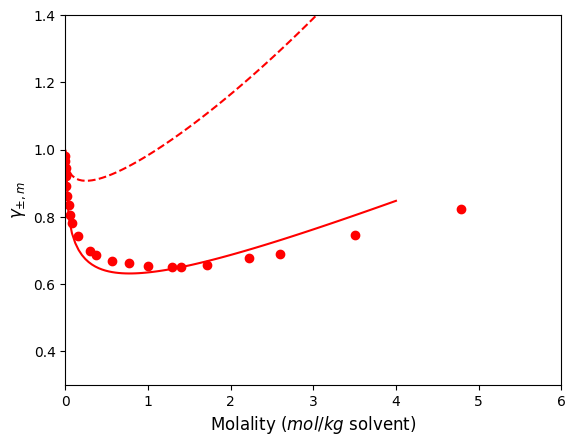

In [138]:
plt.clf()
# plt.plot(x_s,γ)
plt.plot(m,γ,"r")
plt.plot(m,γ_pcsaft,"r--")

plt.plot(Exp[:,1],Exp[:,2], "ro")
plt.xlabel(raw"Molality ($mol/kg$ solvent)",fontsize=12)
plt.ylabel(raw"$\gamma_{\pm,m}$",fontsize=12)
# plt.ylim(0.85,1.2)
# plt.xlim(0,0.2)
plt.xlim(0,6)
plt.ylim(0.3,1.4)
display(plt.gcf())

In [ ]:
model = PCSAFT(["water"])

In [ ]:
Mw = model.neutralmodel.params.Mw.values
mass = [sum(z[i].*Mw*1e-3) for i in 1:100]
vlb = [Clapeyron.lb_volume(model,z[i]) for i in 1:100]
plt.clf()
plt.plot(m,vl)
plt.plot(m,vlb.+1e-5)

plt.xlabel("molality")
plt.ylabel("density")
# plt.ylim(1000,1200)
display(plt.gcf())

## Flash

In [ ]:
revise(Clapeyron)

In [ ]:
model = ESElectrolyte(["water08","acetonitrile"],["sodium","chloride"];
            neutralmodel=pharmaPCSAFT,
            ionmodel=DH,
            RSPmodel=WAvgRSP)
model.neutralmodel.params.epsilon["sodium","sodium"] = 0
model.neutralmodel.params.epsilon["chloride","chloride"] = 0
model.neutralmodel.params.k["acetonitrile","sodium"] = 0.4
model.neutralmodel.params.k["acetonitrile","chloride"] = 0.4
model.neutralmodel.params.segment

In [ ]:
model = ESElectrolyte(["water08","PEG200"],["sodium","chloride"];
            neutralmodel=pharmaPCSAFT,
            ionmodel=DH,
            RSPmodel=WAvgRSP)
model.neutralmodel.params.epsilon["sodium","sodium"] = 0
model.neutralmodel.params.epsilon["chloride","chloride"] = 0
model.neutralmodel.params.k["PEG200","sodium"] = 0.
model.neutralmodel.params.k["PEG200","chloride"] = 0.
model.neutralmodel.params.k["PEG200","water08"] = 0.
model.neutralmodel.params.kT["PEG200","water08"] = 0.


In [ ]:
model = SAFTgammaEMie([("water",["H2O"=>1]),("PEG200",["CH2OH"=>2,"CH2OE"=>6,"cO"=>3])],[("sodium",["Na+"=>1]),("chloride",["Cl-"=>1])])
model = SAFTgammaEMie([("water",["H2O"=>1]),("ethanol",["CH2OH"=>1,"CH3"=>1])],[("sodium",["Na+"=>1]),("chloride",["Cl-"=>1])])

model.neutralmodel.params.epsilon["CH2OH","Na+"] = 500.
model.neutralmodel.params.epsilon["CH2OH","Cl-"] = 90.
# model.neutralmodel.params.epsilon["cO","Na+"] = 10.
# model.neutralmodel.params.epsilon["cO","Cl-"] = 10.

In [ ]:
salt = [("NaCl",["sodium"=>1,"chloride"=>1])]
m = 6
w0 = [0.8,0.2]
z0 = w0./[18.01,40]
z0 ./= sum(z0)
K0 = [2e0,0.5e-1,1e3,1e3]

z = molality_to_composition(model,salt,m,z0)
(x,n,G) = tp_flash(model,1e5,298.15,z,MichelsenTPFlash(equilibrium=:lle,K0=K0))

# μ1 = chemical_potential(model,1e5,298.15,x[1,:];phase=:l)
# μ2 = chemical_potential(model,1e5,298.15,x[2,:];phase=:l)
# μ2-μ1

In [ ]:
z

In [ ]:
volume(model,1e5,298.15,[0.998,0.001,0.0005,0.0005];phase=:l)

In [ ]:
volume(model,1e5,298.15,[0.001,0.998,0.0005,0.0005];phase=:l)

In [ ]:
Clapeyron.a_res(model.neutralmodel,1.9e-5,298.15,[0.4775902297333341,0.009517280848723999,0.2564462447089709,0.256446244708970])

In [ ]:
Clapeyron.a_res(model.neutralmodel,0.0002105546272216393,298.15,[0.04775902295732692,0.9517280845534271,0.00025644624462302265,0.00025644624462302265])

In [ ]:
Clapeyron.x0_volume_liquid(model,298.15,[0.001,0.998,0.0005,0.0005])

In [ ]:
salt = [("NaCl",["sodium"=>1,"chloride"=>1])]
m = LinRange(6,0.1,1000)
z0 = [0.5,0.5]
# z0 = w0./[18.01,200]
# z0 ./= sum(z0)
K0 = [1e3,1e-4,1e5,1e5]
Mw = [18.01,200.,23+35.5]

W = zeros(1000,6)
for i in 1:1000
    println(i)
    z = molality_to_composition(model,salt,m[i],z0)

    (x,n,G) = tp_flash(model,1e5,298.15,z,RRTPFlash(equilibrium=:lle,K0=K0))

    w = x[:,1:3].*Mw'
    w ./= sum(w,dims=2)
    W[i,1:3] = w[1,:]
    W[i,4:6] = w[2,:]

    # println(chemical_potential(model,1e5,298.15,x[1,:];phase=:l))
    # println(chemical_potential(model,1e5,298.15,x[2,:];phase=:l))
    K0 = x[1,:]./x[2,:]
    # println(K0)
    z0 = (x[1,1:2]+x[2,1:2])/2
end

In [ ]:
plt.clf()
figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(9, 9)

tax.boundary()
tax.gridlines(multiple=0.2, color="black")
tax.left_axis_label("benzene", fontsize=16, offset=0.15)
tax.right_axis_label("hexane", fontsize=16, offset=0.15)
tax.bottom_axis_label("methanol", fontsize=16, offset=0.02)

# Plot the data
tax.plot(W[:,1:3], linewidth=2.0,color="b",linestyle="-", label="Gᴱ PC-SAFT{UNIFAC}")
tax.plot(W[:,4:6], linewidth=2.0,color="b",linestyle="-", label="Gᴱ PC-SAFT{UNIFAC}")


tax.ticks(axis="lbr", multiple=0.2, linewidth=1,fontsize=12, tick_formats="%.1f", offset=0.02)

tax.get_axes().axis("off")
tax.clear_matplotlib_ticks()
tax.legend(loc="upper right",frameon=false,fontsize=14)
# tax.savefig("MeOH_Benz_Hx_tern.pdf")
display(plt.gcf())

In [ ]:
PEGMw = 1550
model = pharmaPCSAFT(["water08","PEG200"])

model.params.Mw[2] = PEGMw
model.params.segment[2] = model.params.segment[2]/200*PEGMw
Mw = model.params.Mw.values

In [ ]:
model.params.epsilon_assoc

In [ ]:
bubble_pressure(model,293.15,[1.,0.])

In [ ]:
w = LinRange(0.,0.3,100)
x = w/Mw[2]./(w/Mw[2]+(1 .-w)/Mw[1])
X = Clapeyron.FractionVector.(1 .-x)
a = activity_coefficient.(model,2333.631492274309,293.15,X;phase=:l).*(1 .-x)
a = [a[i][1] for i in 1:100]

In [ ]:
plt.clf()
plt.plot(w,a)
display(plt.gcf())

In [ ]:
PEGMw = 200
model = pharmaPCSAFT(["water08","PEG200"])

model.params.Mw[2] = PEGMw
model.params.segment[2] = model.params.segment[2]/200*PEGMw
Mw = model.params.Mw.values

In [ ]:
x = LinRange(0,1,100)
X = Clapeyron.FractionVector.(x)
p = 1e5
T = 298.15

g = mixing.(model,p,T,X,gibbs_free_energy)

plt.clf()
plt.plot(x,g)
display(plt.gcf())

In [ ]:
model = sCPA(["water"];
        userlocations=(;
        Mw = [18.],
        b = [0.0145],
        a = [1018.3336*8.314*0.0145*1e-3/1e-1],
        c1 = [0.6736],
        n_H = [2],
        n_e = [2],
        epsilon_assoc = Dict((("water","H"),("water","e"))=>2003.1361*8.314/1e2),
        bondvol = Dict((("water","H"),("water","e"))=>69.2),
        Tc = [647.096],
        Pc = [1e6]),
        alpha_userlocations=(;
        Tc = [647.096],
        c1 = [0.6736]))

In [ ]:
p = 1e5
T = LinRange(250,400,100)
ρ = mass_density.(model,p,T;phase=:l)

plt.clf()
plt.plot(T,ρ./1e3)
plt.xlim(250,400)
plt.ylim(0.93,1.04)
display(plt.gcf())